![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Deep Learning: Plant Image Classification

In this notebook we use a subset of the [LifeCLEF2013](https://www.imageclef.org/2013/plant) plant dataset. The dataset contains 250 species in total.

Citing the original task and dataset description from the [project homepage](https://www.imageclef.org/2013/plant):  
>The task will be based on the [Pl@ntView](http://publish.plantnet-project.org/project/plantclef/collection/lifeclef-plant-task) dataset which focuses on 250 herb and tree species
>from France area. It contains 26077 pictures belonging each to one of the 2 following categories:
>- SheetAsBackground (or uniform background) (42%): exclusively pictures of leaves in front of a white
>or colored uniform background produced with a scanner or a camera with a sheet.
>- NaturalBackground (for most of the time cluttered natural background") (58%): free natural photographs
>of different views on different subparts of a plant into the wild.
>
>These 2 main categories can be subdivided into 2 and 5 sub-categories:
>- SheetAsBackground Scan (22%): scan of a single leaf.
>- SheetAsBackground Scan-like (22%): photograph of a single leaf in front of an uniform artificial background.
>- NaturalBackground Leaf (16%): photograph of one leaf or more directly on the plant or near the plant on the floor or other non uniform background.
>- NaturalBackground Flower (18%): photograph of one flower or a group of flowers (inflorescence) directly on the plant.
>- NaturalBackground Fruit (8%): photograph of one fruit or a group of fruits (infructescence) directly on the plant.
>- NaturalBackground Stem (8%): photograph of the stalk, or a stipe, or the bark of the trunk or a main branch of the plant.
>- NaturalBackground Entire (8%): photograph of the entire plant, from the floor to the top.
>
>The following figure provides examples of the 2 categories and 7 sub-categories:
> ![](http://www.imageclef.org/system/files/Diapositive1.png)
>
>These information of categories are reported into the meta-data, in a xml file (one per image) with explicit tags:
>- Acquisition Type: "SheetAsBackground" for scan or scan-like pictures of a leaf, "NaturalBackground" for photograph with a >cluttered background
>- View Content: Leaf, Flower, Fruit, Stem, Entire

While the original project task was to identify plants based on potentially multiple images for the same plant (ie., stem, branch, flower, leaf, or total plant), we will create a simple plant classifer for the most common plants in the dataset using leaf pictures and scans only. However, feel free to experiment and use different subset of the dataset.

## Outline
1. Preprocess dataset metadata (convert individual xml files to pandas dataframe)
2. Subset the original dataset and correct class imbalances
3. Split the images into train, validation and test sets (60, 20, 20)
4. Build and train the CNN model (using transfer learning on a ResNet50/ImageNet model)
    - Define the model
    - Train the head of the model
    - Train the full model (head+stem)
5. Improve the model with progressive resizing (increase image size)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [52]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import xml.etree.cElementTree as ET
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from pathlib import Path
# set a random seed
np.random.seed(42)

## Step 1: Preprocessing the data: metadata

In [8]:
# preprocess xml image description data
def preprocess_image_description(inpath):
    data = defaultdict(list)

    cols = ['filename','plantid','date','locality', 'lat', 'lon', 'author', 'org', 'imagetype', 'content', 'classid',
            'tax_node','tax_regnum','tax_class','tax_subclass','tax_superorder','tax_order','tax_family','tax_genus','tax_species',
            'name', 'year']

    for path in tqdm(list(inpath)):
        xml = ET.parse(str(path))
        root = xml.getroot()

        filename = root.find("FileName").text
        plantid = root.find("IndividualPlantId").text
        date = root.find("Date").text
        locality = root.find("Locality").text

        gps_node = root.find("GPSLocality")
        lat = gps_node.find("Latitude").text
        lon = gps_node.find("Longitude").text

        author = root.find("Author").text
        org   = root.find("Organization").text
        imagetype = root.find("Type").text
        content = root.find("Content").text
        classid = root.find("ClassId").text

        tax_node = root.find("Taxon")
        tax_regnum = tax_node.find("Regnum").text
        tax_class = tax_node.find("Class").text
        tax_subclass = tax_node.find("Subclass").text
        tax_superorder = tax_node.find("Superorder").text
        tax_order = tax_node.find("Order").text
        tax_family = tax_node.find("Family").text
        tax_genus = tax_node.find("Genus").text
        tax_species = tax_node.find("Species").text

        name = root.find("VernacularNames").text
        year = root.find("Year").text

        for c in cols:
            data[c].append(eval(c))

    df = pd.DataFrame(data, columns=cols)
    df['sort_id'] = df.filename.map(lambda x: int("".join([c for c in x if c.isdigit()])))
    
    return df.set_index('sort_id', drop=True).sort_index()

basepath = Path.home() / 'kit_micmor_summerschool_2019'   
imagepath = basepath / 'datasets' / 'eds-2019-datasets-imageclef2013plant' / 'train'
modelpath = basepath 
print(imagepath)
df = preprocess_image_description(imagepath.glob('*.xml'))

/home/micmor2019/kit_micmor_summerschool_2019/datasets/eds-2019-datasets-imageclef2013plant/train


In [9]:
df.year.value_counts()

ImageCLEF2013    10027
ImageCLEF2012     6090
ImageCLEF2011     4868
Name: year, dtype: int64

In [10]:
df.content.value_counts()

Leaf      13284
Flower     3522
Entire     1455
Fruit      1387
Stem       1337
Name: content, dtype: int64

In [11]:
df.tax_genus.value_counts()

Quercus L.                1178
Acer L.                   1113
Populus L.                 651
Viburnum L.                594
Prunus L.                  575
                          ... 
Blechnum L.                 14
Asplenium L.                13
Parthenocissus Planch.      12
Matthiola W.T. Aiton        12
Carthamus L.                11
Name: tax_genus, Length: 170, dtype: int64

## Step 2: Preprocessing the data: image selection and class balancing

In [12]:
# filter for top 20 most common species genuses of leaf images
top20_plants = df[df.content == 'Leaf'].tax_genus.value_counts()[:20].index.values
list(top20_plants)

['Quercus L.',
 'Acer L.',
 'Populus L.',
 'Viburnum L.',
 'Ulmus L.',
 'Phillyrea L.',
 'Prunus L.',
 'Hedera L.',
 'Buxus L.',
 'Pittosporum Banks ex Gaertn.',
 'Crataegus L.',
 'Pistacia L.',
 'Fraxinus L.',
 'Olea L.',
 'Rhus L.',
 'Ruscus L.',
 'Betula L.',
 'Cercis L.',
 'Euphorbia L.',
 'Celtis L.']

In [13]:
# create an other class (all non-top20 images are in this category)
df['top20'] = df.tax_genus.copy(deep=True)
df.loc[~df.tax_genus.isin(top20_plants), 'top20'] = 'other'

In [14]:
# subset the data: only leaf images remain
df_leaves = df[df.content == 'Leaf']

In [15]:
df_leaves.top20.value_counts()

other                           6267
Quercus L.                       826
Acer L.                          769
Populus L.                       561
Viburnum L.                      389
Ulmus L.                         373
Prunus L.                        346
Phillyrea L.                     346
Hedera L.                        312
Buxus L.                         297
Pittosporum Banks ex Gaertn.     297
Crataegus L.                     288
Pistacia L.                      271
Fraxinus L.                      268
Olea L.                          257
Rhus L.                          252
Ruscus L.                        246
Betula L.                        244
Cercis L.                        226
Euphorbia L.                     225
Celtis L.                        224
Name: top20, dtype: int64

**WARNING:** We do have a massive class imbalance !!! This will be a problem, we need to over- or under-sample them to get a more even class distribution.  

For this we apply the following strategy. We oversample all images to the most common species. I.e., rows in the df DataFrame will occur ore often for underrepresented classes. This normally leads to overfitting for those classes. However, in this model we use data augmentation to vary the images in traning (rotation, flipping, croping) and this even duplicate images are never 100% the same.

Since we only consider the top 20 species individually and group all other 230 species into the other class, this class is much bigger. We thus down-sample it to the sice of the largest individual species class.

In [16]:
# rebalance class distribution

# downsample other, oversample all classes to top on-other
df_other  = df_leaves[df_leaves.top20 == 'other']
df_leaves = df_leaves[df_leaves.top20 != 'other']
target_size = df_leaves.top20.value_counts().values.max()

# downsample other to match class size of individual classes
df_other = df_other.sample(n=target_size, replace=False)

lst = [df_leaves]
for class_index, group in df_leaves.groupby('top20'):
    lst.append(group.sample(target_size-len(group), replace=True))

lst.append(df_other)    
df_leaves_bal = pd.concat(lst)
df_leaves_bal.top20.value_counts()

Ruscus L.                       826
Phillyrea L.                    826
Viburnum L.                     826
other                           826
Crataegus L.                    826
Buxus L.                        826
Betula L.                       826
Cercis L.                       826
Rhus L.                         826
Olea L.                         826
Prunus L.                       826
Pistacia L.                     826
Quercus L.                      826
Hedera L.                       826
Euphorbia L.                    826
Fraxinus L.                     826
Pittosporum Banks ex Gaertn.    826
Acer L.                         826
Ulmus L.                        826
Populus L.                      826
Celtis L.                       826
Name: top20, dtype: int64

## Step 3: Split the images into training, validation, and test sets

In [17]:
# 60,20,20 split
train, valid, test = np.split(df_leaves_bal.sample(frac=1), [int(.6*len(df_leaves_bal)), int(.8*len(df_leaves_bal))])
display(len(train))
display(len(valid))
display(len(test))

10407

3469

3470

In [18]:
# we combine train & validation again, not sure if there is a fastai method where train and 
# validation dataframes can be passed as is?
trainval = pd.concat([train, valid])
src = (ImageList.from_df(trainval, imagepath, 'filename')
       .split_by_rand_pct(0.25)
       .label_from_df(cols='top20'))

In [19]:
# define data augmentation
tfms = get_transforms(do_flip=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
# create the databunch (image size, transformations, normalization)
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

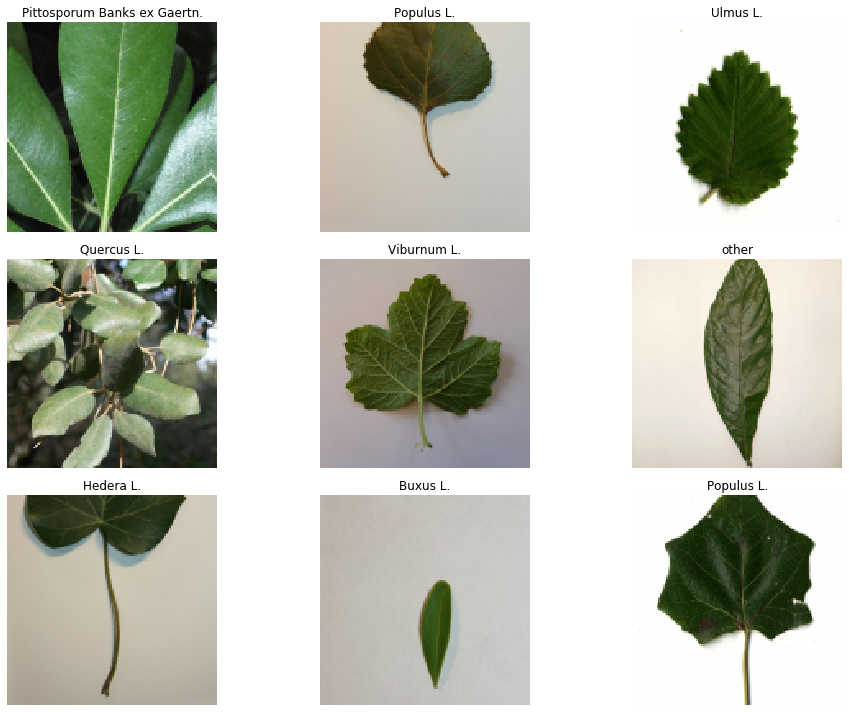

In [21]:
# show some data examples
data.show_batch(rows=3, figsize=(14,10))

## Step 4: Build the CNN model
### Define the architecture

In [22]:
arch = models.resnet50

In [23]:
learn = cnn_learner(data, arch, metrics=error_rate, path=modelpath)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/micmor2019/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.5MB/s]


In [24]:
# model structure
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Train the head section of the model

In [25]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.052072,0.551734,0.160853,02:12
1,0.626933,0.355394,0.108677,01:55
2,0.387310,0.241228,0.072355,01:56
3,0.287768,0.219952,0.067455,01:54


In [26]:
# save the model state
learn.save('plantclassify-stage1')

### Evaluate the model performance

In [27]:
# check the worst results
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

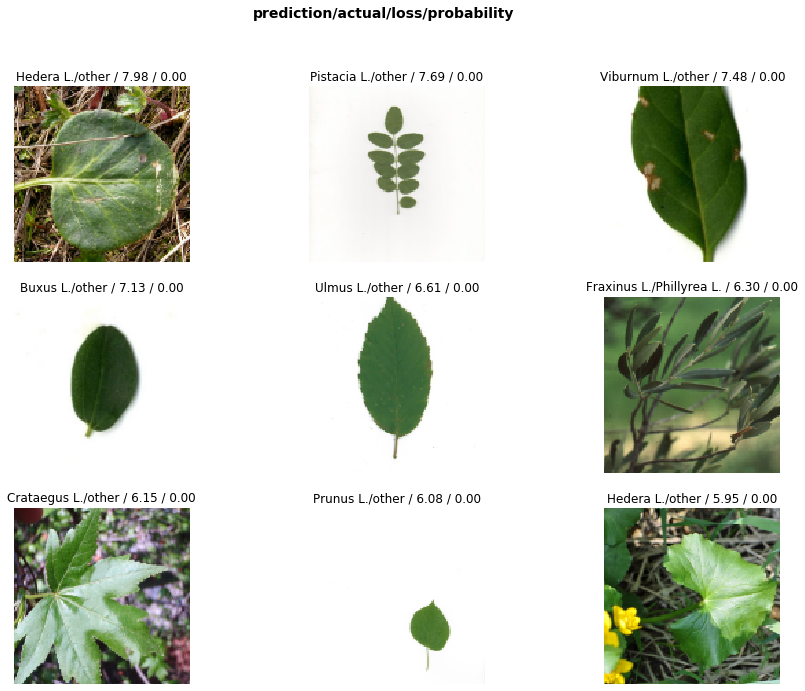

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

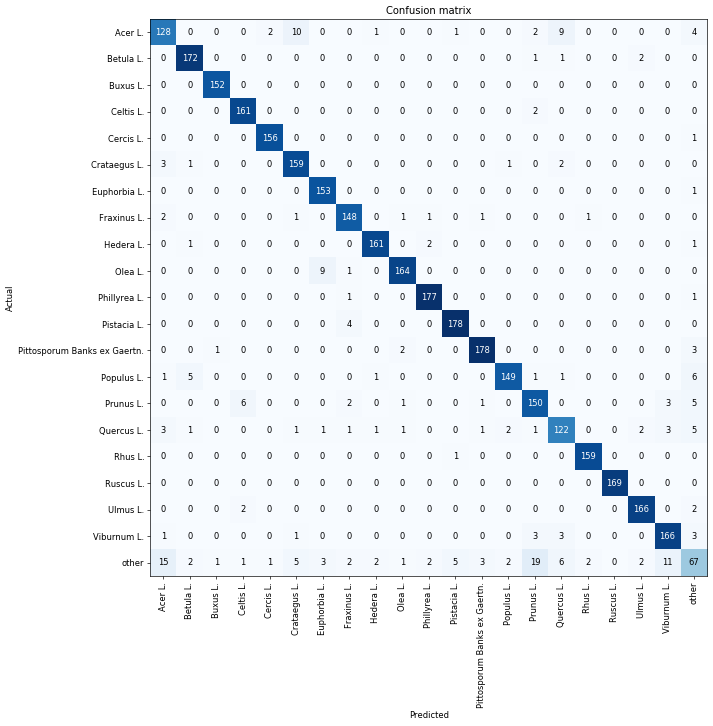

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(min_val=3)

[('other', 'Prunus L.', 19),
 ('other', 'Acer L.', 15),
 ('other', 'Viburnum L.', 11),
 ('Acer L.', 'Crataegus L.', 10),
 ('Acer L.', 'Quercus L.', 9),
 ('Olea L.', 'Euphorbia L.', 9),
 ('Populus L.', 'other', 6),
 ('Prunus L.', 'Celtis L.', 6),
 ('other', 'Quercus L.', 6),
 ('Populus L.', 'Betula L.', 5),
 ('Prunus L.', 'other', 5),
 ('Quercus L.', 'other', 5),
 ('other', 'Crataegus L.', 5),
 ('other', 'Pistacia L.', 5),
 ('Acer L.', 'other', 4),
 ('Pistacia L.', 'Fraxinus L.', 4),
 ('Crataegus L.', 'Acer L.', 3),
 ('Pittosporum Banks ex Gaertn.', 'other', 3),
 ('Prunus L.', 'Viburnum L.', 3),
 ('Quercus L.', 'Acer L.', 3),
 ('Quercus L.', 'Viburnum L.', 3),
 ('Viburnum L.', 'Prunus L.', 3),
 ('Viburnum L.', 'Quercus L.', 3),
 ('Viburnum L.', 'other', 3),
 ('other', 'Euphorbia L.', 3),
 ('other', 'Pittosporum Banks ex Gaertn.', 3)]

### Train the full model

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.451153,0.231872,0.076391,01:57


In [33]:
learn.load('plantclassify-stage1');
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


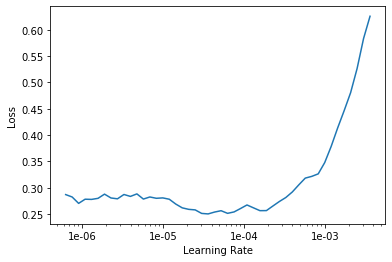

In [34]:
learn.recorder.plot()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.257684,0.206606,0.064284,01:58
1,0.239705,0.182098,0.053906,01:56
2,0.213132,0.164825,0.050159,01:56
3,0.189356,0.152787,0.046988,01:57
4,0.160641,0.152240,0.046411,01:58


In [36]:
learn.save('plantclassify-stage2');

In [37]:
# TEST SOME MORE SIMS

In [38]:
learn.load('plantclassify-stage2');

In [39]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.152842,0.147692,0.043528,01:58
1,0.144351,0.140004,0.042375,01:58
2,0.131053,0.139265,0.038916,01:56


In [40]:
learn.save('plantclassify-stage3');

# Step 5: Improve the model with progressive resizing 

We now increase the model and feed images of size 256x256px (instead of the previous 128x128px). We need a new `databunch` and need to freeze the model again. Then we basically repeat the model training steps from above.

In [41]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [42]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


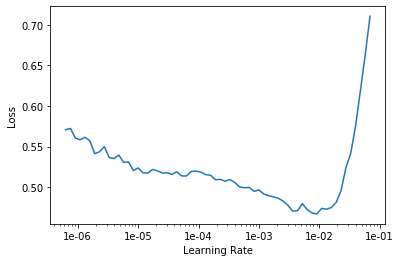

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr=1e-2/2

In [45]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.335238,0.217504,0.063131,03:08
1,0.318969,0.186716,0.057654,03:06
2,0.216331,0.122847,0.034304,03:06
3,0.116607,0.086085,0.029403,03:06
4,0.071151,0.084418,0.025656,03:06


In [46]:
learn.save('plantclassify-stage4')

### Model evaluation (again)

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

In [48]:
interp.most_confused(min_val=3)

[('other', 'Prunus L.', 14),
 ('other', 'Viburnum L.', 10),
 ('other', 'Acer L.', 8),
 ('other', 'Quercus L.', 4),
 ('Acer L.', 'Crataegus L.', 3),
 ('Acer L.', 'Quercus L.', 3),
 ('Prunus L.', 'other', 3),
 ('Viburnum L.', 'other', 3),
 ('other', 'Betula L.', 3),
 ('other', 'Crataegus L.', 3)]

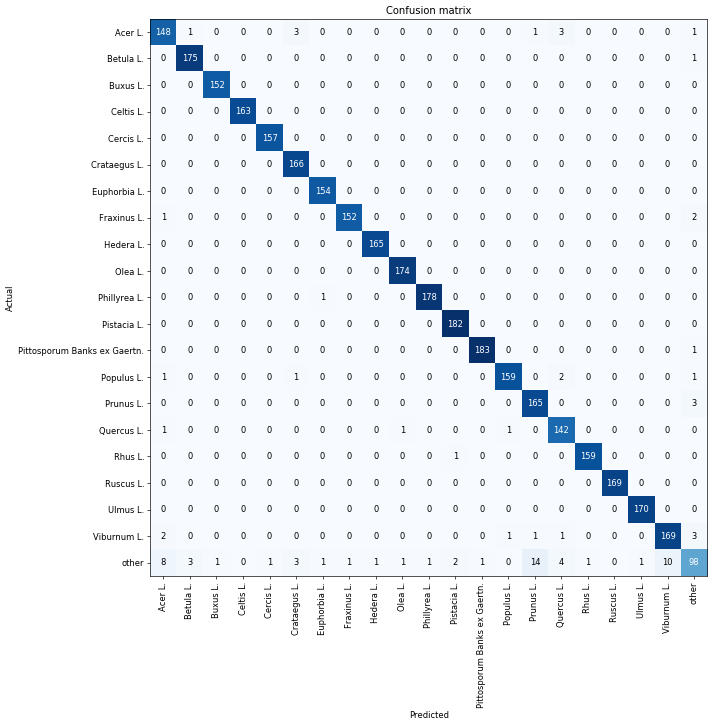

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60, normalize=False)

# Step 6: Model testing

We test our finished model on holdout data (not used in training at all). We have to "force" fastai a bit for this since the test mode is a biut limited. basically, we replace the validation segment of the `databunch` with our testset and call validate().

In [50]:
# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageList.from_df(test, imagepath, 'filename')
        .split_by_rand_pct(0.95)
        .label_from_df(cols='top20')
        .transform(tfms, size=256)
        .databunch(bs=32)
        .normalize(imagenet_stats)
       ) 

In [51]:
learn.validate(data_test.valid_dl, metrics=[error_rate, accuracy])

[0.11200851, tensor(0.0294), tensor(0.9706)]

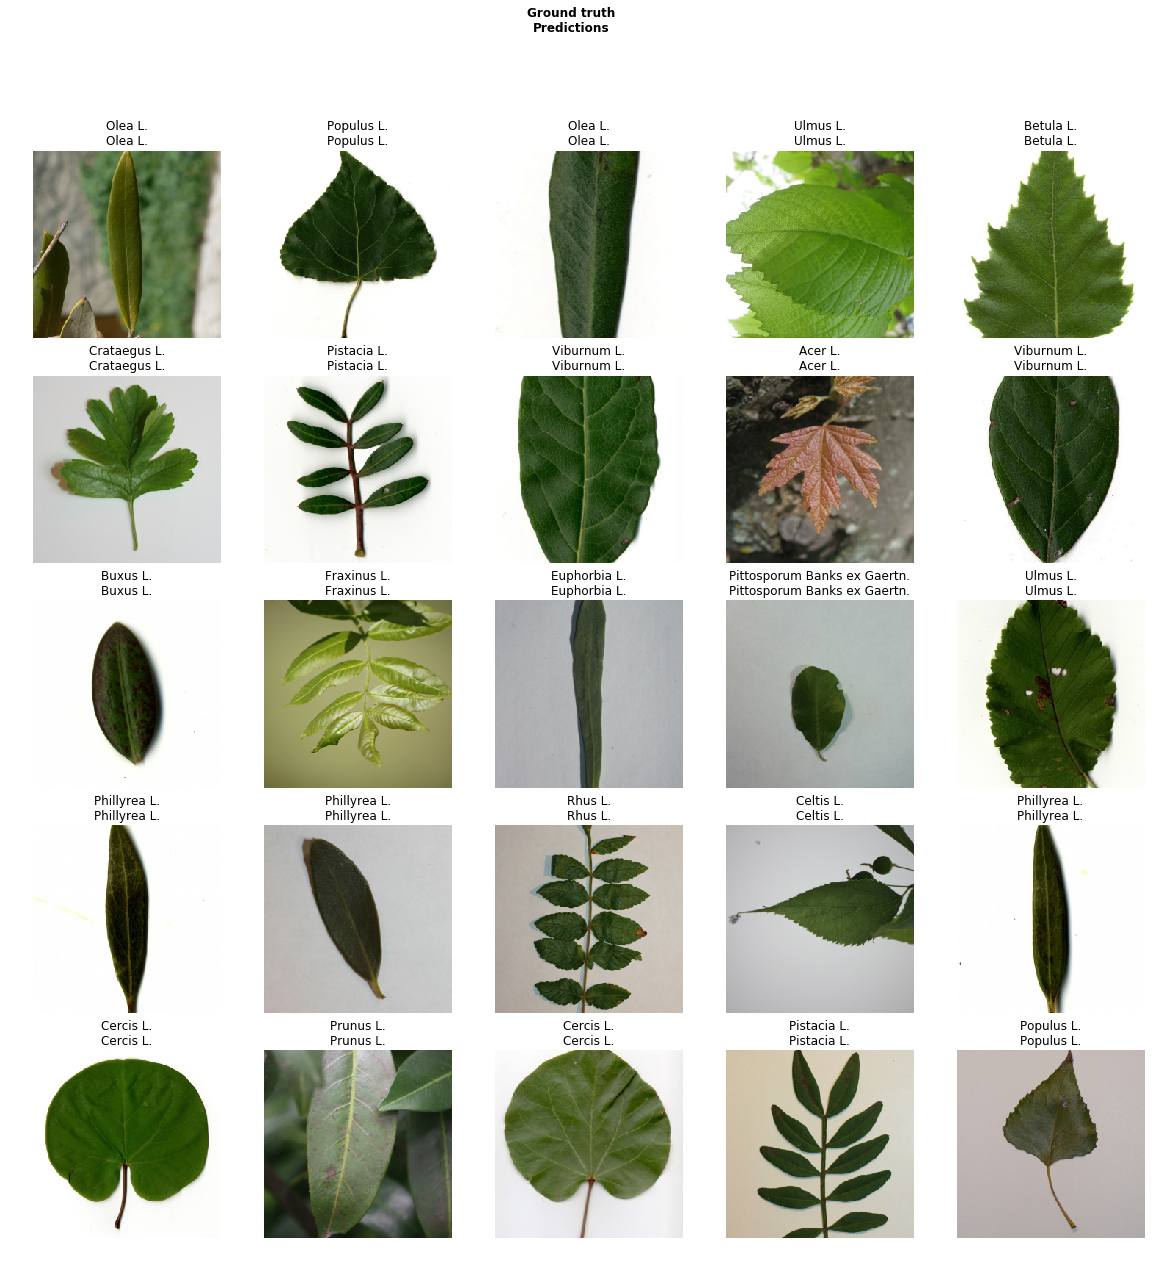

In [48]:
learn.show_results(ds_type=DatasetType.Valid)

## Excercise: experiment!

- What if you train for something else (name ?)
- What happens if you change the transformations?